In [1]:
from elasticsearch import Elasticsearch, helpers
from pprint import pprint
import time
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from collections import Counter
import math
import statistics

In [4]:
es = Elasticsearch('140.118.155.12:9200')

In [81]:
# es query (must條件, size搜尋數量)
def es_query(must, size):
    try:
        q = {"query": {"bool": {"must": must}}, "size": size}
        res = es.search(index=index, doc_type='doc', body=q)
        if res['hits']['total'] != 0:
            return res['hits']['hits']
        else:
            return []
    except Exception as e:
        print(e)
        return None

In [6]:
# 從es中找"所有"符合條件的項目 (cond條件)
def find_all_event(cond):
    try:
        q = {"query": {"bool": {"must": cond}}}
        res = helpers.scan(es, index=index, doc_type='doc', query=q)
        events = []
        for i in res:
            events.append(i)
        return events
    except Exception as e:
        print(e)
        return None

In [7]:
# 找某段時間內(st開始時間~et結束時間)4688(create process)的event
def find_create_process(pid, st, et):
    if pid is None:
        cond = [{'match': {'event_id': '4688'}}, {"range": { "@timestamp": { "gte": st, "lte": et}}}]
    else:
        cond = [{"match": {'event_data.ProcessId': pid}}, {'match': {'event_id': '4688'}}, {"range": { "@timestamp": { "gte": st, "lte": et}}}]
    e = find_all_event(cond)
    return e

In [8]:
# 從所有e(event)找最早的時間 (為了找出一個pid再開始後最早的結束時間)
def find_early_time(e, st):
    if e != [] and e is not None:
        t1 = e[0]['_source']['@timestamp']
        stt = float(str(int(time.mktime(datetime.strptime(st.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))+ '.' + st.split('.')[1].split('Z')[0])
        for i in e:
            t2 = i['_source']['@timestamp']
            t2t = float(str(int(time.mktime(datetime.strptime(t2.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))+ '.' + t2.split('.')[1].split('Z')[0])
            t1t = float(str(int(time.mktime(datetime.strptime(t1.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))+ '.' + t1.split('.')[1].split('Z')[0])
            if stt > t1t:
                t1 = t2
            elif t2t > stt:
                if t2t < t1t:
                    t1 = t2
        return t1
    else:
        return None

In [9]:
# 找一個pid的結束時間，因pid會一直重複使用，所以將這個pid所有4689(process end)的event找出，再找出開始後，最早的結束時間
def find_end_time(pid, st):
    cond = [{"match": {'event_data.ProcessId': pid}}, {'match': {'event_id': '4689'}}, {"range": { "@timestamp": { "gte": st, "lte": "now" }}}]
    e = find_all_event(cond)
    et = find_early_time(e, st)
    return et

In [10]:
# 找一個pid在開始st到結束et之間所做的4663(access object)
def find_related_access(pid, st, et):
    cond = [{'match': {'event_id': '4663'}}, { 'match': {'event_data.ProcessId': pid}}, {"range": { "@timestamp": { "gte": st, "lte": et}}}]
    e = find_all_event(cond)
    return e

In [11]:
# 畫圖st只是將圖命名用，將所有e畫圖
def draw(st, e):
    G = nx.DiGraph()
    stt = str(int(time.mktime(datetime.strptime(st.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))
    for i in range(len(e['process'])):
        if e['type'] is 'File':
            G.add_node(e['object'][i], s='^')
        else:
            G.add_node(e['object'][i], s='o')
        G.add_node(e['process'][i], s='o')
        if e['op'][i] is ('_4416' or '_4419' or '_4423' or '_1538'):
            G.add_edge(e['object'][i], e['process'][i])
        else:
            G.add_edge(e['process'][i], e['object'][i])
    return G, stt

In [12]:
# find external device insert events - Event ID 6416
def find_HID_insert():
    doc_ext = {"query":{"bool":{"must":[{"term":{"event_id":"6416"}},{"prefix":{"event_data.DeviceDescription":"HID"}}]}}, "size": 1000}

    res_ext = es.search(index=index, doc_type='doc', body=doc_ext, sort='@timestamp')

    ext_events = res_ext['hits']['hits']
    print(res_ext['hits']['total'], len(ext_events))
    
    return ext_events

In [13]:
# 一個usb插入可能產生多個6416(因usb可包含多項功能)，將同一秒內的視為相同的usb
def usb_time(ext_events):
    usb_timestamp = []

    for i in ext_events:
        if usb_timestamp == []:
            usb_timestamp.append(i['_source']['@timestamp'])
        else:
            st = usb_timestamp[-1]
            tt = float(str(int(time.mktime(datetime.strptime(st.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))+ '.' + st.split('.')[1].split('Z')[0])
            it = i['_source']['@timestamp']
            itt = float(str(int(time.mktime(datetime.strptime(it.split('.')[0], "%Y-%m-%dT%H:%M:%S").timetuple())))+ '.' + it.split('.')[1].split('Z')[0])
            if itt > (tt + 1):
                usb_timestamp.append(it)
    print(len(usb_timestamp))
    return usb_timestamp

In [14]:
# 將所有event組起來，t_range為插入usb後多久，max_level為數的層數(不重要XD)
def find_whole_events(t_range, max_level, usb_timestamp):
    pid = []
    all_graph = []
    graph_t = []
    all_node = []

    for t in usb_timestamp:
        events = {'process':[], 'op':[], 'object':[], 'type': []}
        # 時間處理，設定usb end time(由t_range決定)
        stime = t
        minute = int(t.split(':')[1]) + t_range
        hour = int((t.split(':')[0]).split('T')[1])
        date = (t.split(':')[0]).split('T')[0]
        if minute < 10:
            mm = '0' + str(minute)
        elif minute > 60:
            minute = minute - 60
            mm = '0' + str(minute)
            hour += 1
        elif minute == 60:
            mm = '00'
            hour += 1
        else:
            mm = str(minute)
        if hour < 10:
            hh = '0' + str(hour)
        elif hour > 23:
            hh = '23'
        else:
            hh = str(hour)
        etime = date + 'T' + hh + ':' + mm + ':' + t.split(':')[2]
        # 找所有create process(4688)
        events_4688 = find_create_process(None, stime, etime)
        # 一層一層找
        level = 0
        while events_4688 != [] and events_4688 is not None and level <= max_level:
            create_event = events_4688
            events_4688 = []
            for i in create_event:
                # metasploit為我錄的攻擊時會產生的，這是因為使用的平台為kali，但為了模擬實際行為，因此過濾掉
                if 'C:\metasploit' not in i['_source']['event_data']['ParentProcessName'] and 'C:\metasploit' not in i['_source']['event_data']['NewProcessName']:
                    st = i['_source']['@timestamp']
                    et = find_end_time(i['_source']['event_data']['NewProcessId'], st)
                    pid.append(i['_source']['event_data']['ProcessId'])
                    events['process'].append(i['_source']['event_data']['ParentProcessName'])
                    events['op'].append('_4688')
                    events['object'].append(i['_source']['event_data']['NewProcessName'])
                    events['type'].append('Process')
                    events_4663 = find_related_access(i['_source']['event_data']['NewProcessId'], st, et)
                    events_4663.extend(find_related_access(i['_source']['event_data']['ProcessId'], st, et))
                    new_create_events = find_create_process(i['_source']['event_data']['NewProcessId'], st, et)
                    if new_create_events != [] and new_create_events is not None:
                        events_4688.extend(new_create_events)
                    for j in events_4663:
                        if 'C:\metasploit' not in j['_source']['event_data']['ProcessName']:
                            pid.append(j['_source']['event_data']['ProcessId'])
                            events['process'].append(j['_source']['event_data']['ProcessName'])
                            events['op'].append('_' + j['_source']['event_data']['AccessList'][2:6])
                            events['object'].append(j['_source']['event_data']['ObjectName'])
                            events['type'].append(j['_source']['event_data']['ObjectType'])
            level += 1
        print(t)
        # 畫圖 G為圖，tt為時間標籤
        G, tt = draw(t, events)
        graph_t.append(tt)
        all_graph.append(G.edges())
        all_node.append(G.nodes())
    return all_graph, all_node, graph_t

In [15]:
# 所有要查找的es目錄
indexs = ['winlogbeat-6.2.4-2018.05.16', 'winlogbeat-6.2.4-2018.05.23', 'winlogbeat-6.2.4-2018.05.28', 
          'winlogbeat-6.2.4-2018.05.29', 'winlogbeat-6.2.4-2018.05.30', 'winlogbeat-6.2.4-2018.05.31',
          'winlogbeat-6.2.4-2018.06.05', 'winlogbeat-6.2.4-2018.06.06', 'winlogbeat-6.2.4-2018.06.07',
          'winlogbeat-6.2.4-2018.06.11', 'winlogbeat-6.2.4-2018.06.12']

In [29]:
# 攻擊的時間點，標記用
attack_t = ['2018-05-29T18:28:45.106Z', '2018-05-29T18:29:37.418Z', '2018-05-29T18:31:00.855Z', '2018-05-29T18:32:39.485Z', 
             '2018-05-29T18:34:19.657Z', '2018-06-12T14:29:00.506Z', '2018-06-12T14:57:43.236Z', '2018-06-12T15:10:03.975Z',
             '2018-06-12T15:23:35.616Z', '2018-06-12T15:41:28.197Z']

In [57]:
# test

# test的usb插入時間
timestamp = [['2018-05-16T06:13:49.754Z', '2018-05-16T07:56:24.324Z', '2018-05-16T07:56:29.765Z', '2018-05-16T08:01:32.813Z', 
              '2018-05-16T08:02:56.242Z', '2018-05-16T08:52:11.643Z', '2018-05-16T10:08:39.708Z', '2018-05-16T10:21:13.136Z'], 
             ['2018-05-23T10:13:19.598Z', '2018-05-23T15:33:03.470Z'], 
             ['2018-05-28T03:11:47.298Z', '2018-05-28T09:19:07.754Z', '2018-05-28T09:20:14.300Z', '2018-05-28T09:44:51.264Z', 
              '2018-05-28T14:21:45.234Z', '2018-05-28T14:22:43.504Z', '2018-05-28T15:40:52.900Z'], 
             ['2018-05-29T04:31:51.722Z', '2018-05-29T04:37:19.513Z', '2018-05-29T10:09:54.536Z', '2018-05-29T17:23:40.016Z',
              '2018-05-29T18:36:01.082Z', '2018-05-29T18:55:29.999Z', '2018-05-29T19:12:17.161Z', '2018-05-29T19:15:04.205Z',
              '2018-05-29T19:20:40.778Z', '2018-05-29T19:23:25.424Z', '2018-05-29T18:28:45.106Z', '2018-05-29T18:29:37.418Z',
              '2018-05-29T18:31:00.855Z', '2018-05-29T18:32:39.485Z', '2018-05-29T18:34:19.657Z'],
             ['2018-05-30T04:52:57.971Z', '2018-05-30T06:44:00.012Z', '2018-05-30T06:54:56.819Z', '2018-05-30T10:35:46.003Z',
              '2018-05-30T11:00:15.784Z', '2018-05-30T14:24:38.957Z'],
             ['2018-05-31T06:14:47.201Z'],
             ['2018-06-05T13:33:58.055Z', '2018-06-05T15:42:36.577Z'],
             ['2018-06-06T08:56:11.317Z', '2018-06-06T10:37:08.306Z'],
             ['2018-06-07T19:21:03.994Z', '2018-06-07T20:33:59.822Z'],
             ['2018-06-11T19:45:32.899Z', '2018-06-11T20:03:26.761Z'],
             ['2018-06-12T14:29:00.506Z', '2018-06-12T14:01:58.516Z', '2018-06-12T14:57:43.236Z', '2018-06-12T15:10:03.975Z',
              '2018-06-12T15:23:35.616Z', '2018-06-12T15:41:28.197Z']
            ]

In [17]:
# train

# train的usb插入時間
timestamp = [['2018-05-16T06:13:49.754Z', '2018-05-16T07:56:24.324Z', '2018-05-16T07:56:29.765Z', '2018-05-16T08:01:32.813Z', 
              '2018-05-16T08:02:56.242Z'], 
             ['2018-05-23T10:13:19.598Z'], 
             ['2018-05-28T03:11:47.298Z', '2018-05-28T09:19:07.754Z', 
              '2018-05-28T14:21:45.234Z', '2018-05-28T14:22:43.504Z', '2018-05-28T15:40:52.900Z'], 
             [ '2018-05-29T10:09:54.536Z', '2018-05-29T17:23:40.016Z',
              '2018-05-29T18:36:01.082Z', '2018-05-29T18:55:29.999Z', '2018-05-29T19:12:17.161Z', '2018-05-29T19:15:04.205Z',
              '2018-05-29T19:20:40.778Z', '2018-05-29T19:23:25.424Z', '2018-05-29T18:28:45.106Z', '2018-05-29T18:29:37.418Z'],
             ['2018-05-30T04:52:57.971Z', '2018-05-30T06:44:00.012Z'],
             ['2018-05-31T06:14:47.201Z'],
             ['2018-06-05T13:33:58.055Z'],
             ['2018-06-06T08:56:11.317Z', '2018-06-06T10:37:08.306Z'],
             ['2018-06-07T19:21:03.994Z', '2018-06-07T20:33:59.822Z'],
             ['2018-06-11T19:45:32.899Z', '2018-06-11T20:03:26.761Z'],
             ['2018-06-12T14:29:00.506Z', '2018-06-12T14:01:58.516Z', '2018-06-12T14:57:43.236Z', '2018-06-12T15:10:03.975Z',
              '2018-06-12T15:23:35.616Z', '2018-06-12T15:41:28.197Z']
            ]

In [58]:
# 主function，把所有圖存起來(兩分鐘)
all_graph2 = []
all_node2 = []
graph_t = []

for index, times in zip(indexs, timestamp):
#     insert_events = find_HID_insert()
    insert_times = times
    t_range = 2  # t_range <= 10
    max_level = 3
    g, n, t = find_whole_events(t_range, max_level, insert_times)
    
    all_graph2.extend(g)
    all_node2.extend(n)
    graph_t.extend(times)

2018-05-16T06:13:49.754Z
2018-05-16T07:56:24.324Z
2018-05-16T07:56:29.765Z
2018-05-16T08:01:32.813Z
2018-05-16T08:02:56.242Z
2018-05-16T08:52:11.643Z
2018-05-16T10:08:39.708Z
2018-05-16T10:21:13.136Z
2018-05-23T10:13:19.598Z
2018-05-23T15:33:03.470Z
2018-05-28T03:11:47.298Z
2018-05-28T09:19:07.754Z
2018-05-28T09:20:14.300Z
2018-05-28T09:44:51.264Z
2018-05-28T14:21:45.234Z
2018-05-28T14:22:43.504Z
2018-05-28T15:40:52.900Z
2018-05-29T04:31:51.722Z
2018-05-29T04:37:19.513Z
2018-05-29T10:09:54.536Z
2018-05-29T17:23:40.016Z
2018-05-29T18:36:01.082Z
2018-05-29T18:55:29.999Z
2018-05-29T19:12:17.161Z
2018-05-29T19:15:04.205Z
2018-05-29T19:20:40.778Z
2018-05-29T19:23:25.424Z
2018-05-29T18:28:45.106Z
2018-05-29T18:29:37.418Z
2018-05-29T18:31:00.855Z
2018-05-29T18:32:39.485Z
2018-05-29T18:34:19.657Z
2018-05-30T04:52:57.971Z
2018-05-30T06:44:00.012Z
2018-05-30T06:54:56.819Z
2018-05-30T10:35:46.003Z
2018-05-30T11:00:15.784Z
2018-05-30T14:24:38.957Z
2018-05-31T06:14:47.201Z
2018-06-05T13:33:58.055Z


In [59]:
# 算event的rareness score(idf)
edges_token = []
edges_token += [j for i in all_graph2 for j in i]
print('number of events:', len(edges_token))
event_count = Counter(edges_token)
event_score = {}

for e in event_count:
    idf = math.log(len(all_graph2) / (1 + sum(1 for i in all_graph2 if e in i)))
    event_score.update({e: idf})

number of events: 973


In [60]:
# 算object的rareness score(idf)
nodes_token = []
nodes_token += [j for i in all_node2 for j in i]
print('number of objects:', len(nodes_token))
obj_count = Counter(nodes_token)
obj_score = {}

for o in obj_count:
    idf = math.log(len(all_node2) / (1 + sum(1 for i in all_node2 if o in i)))
    obj_score.update({o: idf})

number of objects: 1031


In [61]:
# 把event和object的rareness score正規化到0-1，並存成一個dict(all_score2)兩分鐘的rareness score
all_score2 = {}

event_max = max(event_score.keys(), key=(lambda k: event_score[k]))
event_min = min(event_score.keys(), key=(lambda k: event_score[k]))

oldrange = event_score[event_max] - event_score[event_min]
newmin = 0
newmax = 1
newrange = newmax - newmin

scale = newrange / oldrange
for i in event_score:
    all_score2[i] = (event_score[i] - event_score[event_min]) * scale + newmin

obj_max = max(obj_score.keys(), key=(lambda k: obj_score[k]))
obj_min = min(obj_score.keys(), key=(lambda k: obj_score[k]))

obj_oldrange = obj_score[obj_max] - obj_score[obj_min]
obj_scale = newrange / obj_oldrange
for i in obj_score:
    all_score2[i] = (obj_score[i] - obj_score[obj_min]) * obj_scale + newmin

In [62]:
# 主function，把所有圖存起來(一分鐘)，算pagerank用
all_graph = []
all_node = []
graph_t = []

start = time.time()

for index, times in zip(indexs, timestamp):
#     insert_events = find_HID_insert()
    insert_times = times
    t_range = 1  # t_range <= 10
    max_level = 3
    g, n, t = find_whole_events(t_range, max_level, insert_times)
    
    all_graph.extend(g)
    all_node.extend(n)
    graph_t.extend(times)
    
end = time.time()

2018-05-16T06:13:49.754Z
2018-05-16T07:56:24.324Z
2018-05-16T07:56:29.765Z
2018-05-16T08:01:32.813Z
2018-05-16T08:02:56.242Z
2018-05-16T08:52:11.643Z
2018-05-16T10:08:39.708Z
2018-05-16T10:21:13.136Z
2018-05-23T10:13:19.598Z
2018-05-23T15:33:03.470Z
2018-05-28T03:11:47.298Z
2018-05-28T09:19:07.754Z
2018-05-28T09:20:14.300Z
2018-05-28T09:44:51.264Z
2018-05-28T14:21:45.234Z
2018-05-28T14:22:43.504Z
2018-05-28T15:40:52.900Z
2018-05-29T04:31:51.722Z
2018-05-29T04:37:19.513Z
2018-05-29T10:09:54.536Z
2018-05-29T17:23:40.016Z
2018-05-29T18:36:01.082Z
2018-05-29T18:55:29.999Z
2018-05-29T19:12:17.161Z
2018-05-29T19:15:04.205Z
2018-05-29T19:20:40.778Z
2018-05-29T19:23:25.424Z
2018-05-29T18:28:45.106Z
2018-05-29T18:29:37.418Z
2018-05-29T18:31:00.855Z
2018-05-29T18:32:39.485Z
2018-05-29T18:34:19.657Z
2018-05-30T04:52:57.971Z
2018-05-30T06:44:00.012Z
2018-05-30T06:54:56.819Z
2018-05-30T10:35:46.003Z
2018-05-30T11:00:15.784Z
2018-05-30T14:24:38.957Z
2018-05-31T06:14:47.201Z
2018-06-05T13:33:58.055Z


In [63]:
# 將event畫出bipartite graph
node_edge_1 = []

print(len(graph_t))
# Bipartite Graph
BE = nx.Graph()
# plt.figure(figsize=(40,40))
BE.add_nodes_from(graph_t, bipartite=0)
for index, i in enumerate(all_graph):
    for j in i:
        BE.add_node(j, bipartite=1)
        node_edge_1.append(j)
        BE.add_edge(graph_t[index], j)

53


In [64]:
# 將object畫出bipartite graph
node_obj_1 = []

print(len(graph_t))
# Bipartite Graph
BO = nx.Graph()
# plt.figure(figsize=(40,40))
BO.add_nodes_from(graph_t, bipartite=0)
# B.add_node([j for i in all_graph for j in i], bipartite=1)
for index, i in enumerate(all_node):
    for j in i:
        BO.add_node(j, bipartite=1)
        node_obj_1.append(j)
        BO.add_edge(graph_t[index], j)

53


In [65]:
# event One mode Projection
nodes = set(node_edge_1)
PE = nx.projected_graph(BE, nodes)

In [66]:
# object One mode Projection
nodes = set(node_obj_1)
PO = nx.projected_graph(BO, nodes)

In [67]:
# pagerank起始設定
for i in PE.edges():
    if (all_score2[i[0]] > 0.8 and all_score2[i[1]] < 0.3) or (all_score2[i[1]] > 0.8 and all_score2[i[0]] < 0.3):
        PE[i[0]][i[1]]['weight'] = 0.01
    else:
        PE[i[0]][i[1]]['weight'] = 0.99
        
for i in PO.edges():
    if (all_score2[i[0]] > 0.8 and all_score2[i[1]] < 0.3) or (all_score2[i[1]] > 0.8 and all_score2[i[0]] < 0.3):
        PO[i[0]][i[1]]['weight'] = 0.01
    else:
        PO[i[0]][i[1]]['weight'] = 0.99
        
enscore = {}
high = 0
low = 0

for i in PE.nodes():
    if all_score2[i] > 0.8:
        enscore.update({i:-1})
        high += 1
    elif all_score2[i] < 0.3:
        enscore.update({i:1})
        low += 1
    else:
        enscore.update({i:0})
        
onscore = {}
high = 0
low = 0

for i in PO.nodes():
    if all_score2[i] > 0.8:
        onscore.update({i:-1})
        high += 1
    elif all_score2[i] < 0.3:
        onscore.update({i:1})
        low += 1
    else:
        onscore.update({i:0})

In [68]:
# 計算event pagerank
Epr = nx.pagerank(PE, max_iter=100, nstart=enscore)

In [69]:
# 計算object pagerank
Opr = nx.pagerank(PO, max_iter=100, nstart=onscore)

In [70]:
# 正規畫pagerank score(0-1)，並存成dict(pr_nom)
pr_nom = {}

Epr_max = max(Epr.keys(), key=(lambda k: Epr[k]))
Epr_min = min(Epr.keys(), key=(lambda k: Epr[k]))

Epr_oldrange = Epr[Epr_max] - Epr[Epr_min]
newmin = 0
newmax = 1
newrange = newmax - newmin

Epr_scale = newrange / Epr_oldrange
for i in Epr:
    pr_nom[i] = (Epr[i] - Epr[Epr_min]) * Epr_scale + newmin
    
Opr_max = max(Opr.keys(), key=(lambda k: Opr[k]))
Opr_min = min(Opr.keys(), key=(lambda k: Opr[k]))

Opr_oldrange = Opr[Opr_max] - Opr[Opr_min]

Opr_scale = newrange / Opr_oldrange
for i in Opr:
    pr_nom[i] = (Opr[i] - Opr[Opr_min]) * Opr_scale + newmin

In [71]:
# 計算每張圖的分數，會有兩個，一個是所有event，一個是所有object
path_score = {}
node_score = {}

for index, i in enumerate(all_graph):
    p_score = 0
    for j in i:
        if j in pr_nom:
            p_score += pr_nom[j]
            
    if len(i) != 0:
        path_score[graph_t[index]] = p_score / len(i)
    else:
        path_score[graph_t[index]] = 0
        
for index, i in enumerate(all_node):
    n_score = 0
    for j in i:
        if j in pr_nom:
            n_score += pr_nom[j]
    if len(i) != 0:
        node_score[graph_t[index]] = n_score / len(i)
    else:
        node_score[graph_t[index]] = 0

In [72]:
# 取feature
scatter_x = []
scatter_y = []
node_len = []
edge_len = []
lowidf_event = []
lowidf_obj = []
highidf_event = []
highidf_obj = []
labels = []
colors = []

for index, i in enumerate(graph_t):
    scatter_x.append(path_score[i])
    scatter_y.append(node_score[i])
    node_len.append(len(all_node2[index]))
    edge_len.append(len(all_graph2[index]))
    lowidf_event.append(1 + sum(1 for i in all_graph2[index] if all_score2[i] < 0.3))
    lowidf_obj.append(1 + sum(1 for i in all_node2[index] if all_score2[i] < 0.3))
    highidf_event.append(1 + sum(1 for i in all_graph2[index] if all_score2[i] > 0.8))
    highidf_obj.append(1 + sum(1 for i in all_node2[index] if all_score2[i] > 0.8))

In [73]:
# feature正規化
node_len_nor = [i/max(node_len) for i in node_len]
edge_len_nor = [i/max(edge_len) for i in edge_len]
lowidf_event_nor = [i/max(lowidf_event) for i in lowidf_event]
lowidf_obj_nor = [i/max(lowidf_obj) for i in lowidf_obj]
highidf_event_nor = [i/max(highidf_event) for i in highidf_event]
highidf_obj_nor = [i/max(highidf_obj) for i in highidf_obj]

In [45]:
import numpy as np
import random
import pandas as pd

In [74]:
isattack = []
for i in graph_t:
    if i in attack_t:
        isattack.append(1)
    else:
        isattack.append(0)

In [75]:
# 轉換格式，使用numpy
featd = []
for l, x, y, ln, le, lse, lso, hse, hso, yn in zip(graph_t, scatter_x, scatter_y, node_len_nor, edge_len_nor, lowidf_event_nor, lowidf_obj_nor, highidf_event_nor, highidf_obj_nor, isattack):
    data = [x, y, ln, le, lse, hso]
    featd.append(data)
    
selfeature = np.array(featd)

In [76]:
# PCA找兩個主要的feature
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
feature = pca.fit_transform(selfeature)
print(pca.components_)

[[ 0.30064502  0.22292661  0.34377308  0.3457859   0.72608578  0.30816865]
 [-0.28420015 -0.29968016  0.44892418  0.45195171 -0.42669547  0.49148732]]


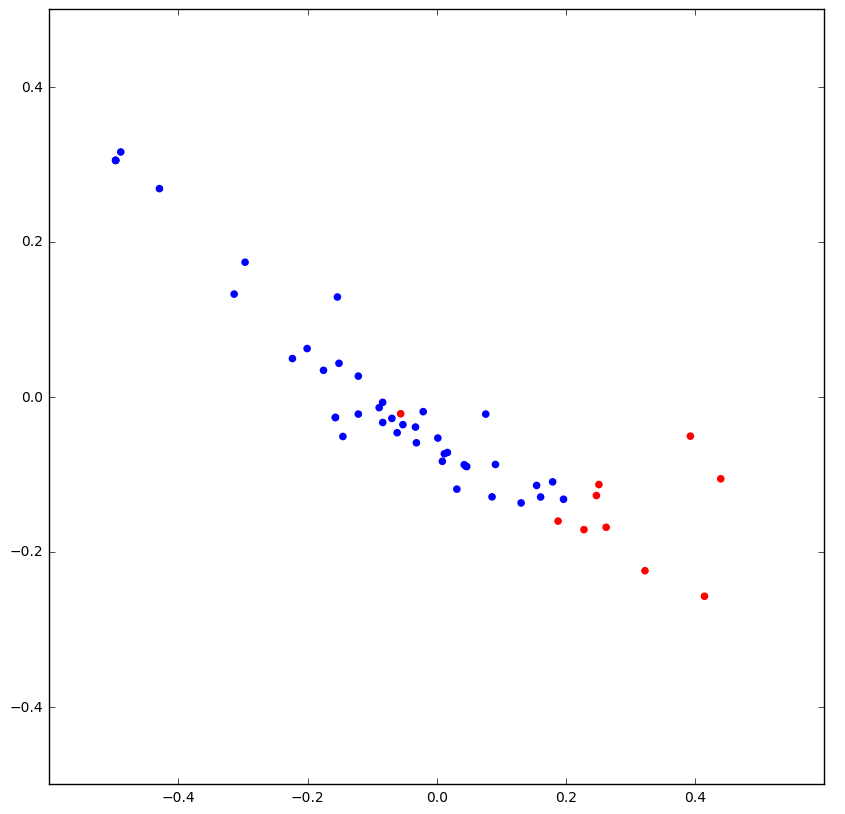

In [85]:
# PCA結果
ll = []
cc = []
xx = []
yy = []

for index, i in enumerate(graph_t):
    if i in attack_t:
        ll.append('')
        cc.append('red')
    else:
        ll.append('')
        cc.append('blue')
    xx.append(feature[index,0])
    yy.append(feature[index,1])

plt.figure(figsize=(10,10))
plt.xlim(-0.6,0.6)
plt.ylim(-0.5,0.5)
plt.scatter(xx, yy, color = cc)
# plt.xlabel("USB event score")
# plt.ylabel("USB obj score")
for l, x, y in zip(ll, xx, yy):
    plt.annotate(l, xy=(x, y))
plt.savefig('pca.png')
plt.show()

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [55]:
# training data
feature1 = [i[0] for i in feature]
feature2 = [i[1] for i in feature]
attack = isattack
dd = pd.DataFrame({'f1': feature1, 'f2': feature2, 'isattack': attack})

In [79]:
# train model
clf = RandomForestClassifier(n_estimators=30, max_depth=100)

# randomforest_parameters = {'n_estimators':[100, 200, 300, 400, 500], 'max_depth':[30, 50, 100, 150]}
# clf = GridSearchCV(RandomForestClassifier(n_jobs = -1), randomforest_parameters, cv = 10, scoring='f1')
# clf.fit(X_rf, y_rf)
# # print ("\tBest parameters set found on development set:")
# print (clf.best_params_)
# prediction = clf.predict(X_rf)
# confusion = confusion_matrix(y_rf, prediction)
# print (confusion)

df_percent = dd.sample(frac=1)
X_rf = df_percent[['f1', 'f2']]
y_rf = df_percent[['isattack']]
df = pd.concat([dd, df_percent])
df = df.reset_index(drop=True)
df_gpby = df.groupby(list(df.columns))
idx = [x[0] for x in df_gpby.groups.values() if len(x) == 1]
test = df.reindex(idx)

clf.fit(X_rf, y_rf)
pred = clf.predict(dd[['f1', 'f2']])
tn, fp, fn, tp = confusion_matrix(dd[['isattack']], pred).ravel()
print(tn, fp, fn, tp)

30 0 0 7


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [80]:
# test
test_feature1 = [i[0] for i in feature]
test_feature2 = [i[1] for i in feature]
test_dd = pd.DataFrame({'f1': test_feature1, 'f2': test_feature2, 'isattack': isattack})
pred = clf.predict(test_dd[['f1', 'f2']])
tn, fp, fn, tp = confusion_matrix(test_dd[['isattack']], pred).ravel()
print(tn, fp, fn, tp)

42 1 1 9


In [ ]:
for i, j, k in zip(graph_t, isattack, pred):
    print(i,j,k)